# Исследование надёжности заёмщиков

Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга

# Описание данных
`children` — количество детей в семье  
`days_employed` — общий трудовой стаж в днях  
`dob_years` — возраст клиента в годах  
`education` — уровень образования клиента  
`education_id` — идентификатор уровня образования  
`family_status` — семейное положение  
`family_status_id` — идентификатор семейного положения  
`gender` — пол клиента  
`income_type` — тип занятости  
`debt` — имел ли задолженность по возврату кредитов  
`total_income` — ежемесячный доход  
`purpose` — цель получения кредита  

## Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter

Установка отображения не более 2х знаков после запятой и игнорирование предупреждений

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
import warnings
warnings.simplefilter('ignore')

Загружаем данные

In [4]:
df = pd.read_csv('/datasets/data.csv')
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"-8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"-4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"-5,623.42",33,Среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"-4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу


In [5]:
data = df.copy(deep=True)

Функция для ознакомления с данными

In [6]:
def first_glance(data):
    display(data.info())
    print()
    for i in range(len(data.columns)):
        column = data.columns[i]
        print(data[column].value_counts())
        print('---') 

In [7]:
first_glance(data) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


None


 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64
---
-327.69      1
-1,580.62    1
-4,122.46    1
-2,828.24    1
-2,636.09    1
            ..
-7,120.52    1
-2,146.88    1
-881.45      1
-794.67      1
-3,382.11    1
Name: days_employed, Length: 19351, dtype: int64
---
35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
66    183
22    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64
---
среднее                13750
в

**Вывод**

1. в столбцах _days_employed, total_income_ и _gender_ содержатся пустые значения
2. в столбцах _days_employed_ и _children_ содержатся отрицательные значения
3. в столбце _education_ значения в разных регистрах
4. в столбце _family_status_ регистр отличается, но дублирование значений отсуствует

## Предобработка данных

### Обработка пропусков

In [8]:
data[data['days_employed'].isna()].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


In [9]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [10]:
data.isna().mean()

children           0.00
days_employed      0.10
dob_years          0.00
education          0.00
education_id       0.00
family_status      0.00
family_status_id   0.00
gender             0.00
income_type        0.00
debt               0.00
total_income       0.10
purpose            0.00
dtype: float64

пропуски в столбцах _days_employed_ и _total_income_ составили 10%, что составляет немалую часть данных

Функция по построению графиков распределения и боксплот

In [11]:
def distribution(series):
    plt.figure(figsize=(15,8))
    sns.set_style('darkgrid')
  
    plt.subplot(211)
    plt.title('Распределение ' + series.name)
    sns.distplot(series)
    
    plt.subplot(212)
    sns.boxplot(series)

    plt.show()
    display(series.describe())

# Отрицательные значения в столбце "стаж"

Заменим отрицательные значения в графе стаж на положительные, скорее всего клиенты при заполнении формы перепутали поля

In [12]:
data['days_employed'] = data['days_employed'].apply(abs)

In [13]:
len(data[data['days_employed'] < 0])

0

# Замена пропусков в столбце о доходах

In [14]:
data[data['total_income'].isna()].head(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости


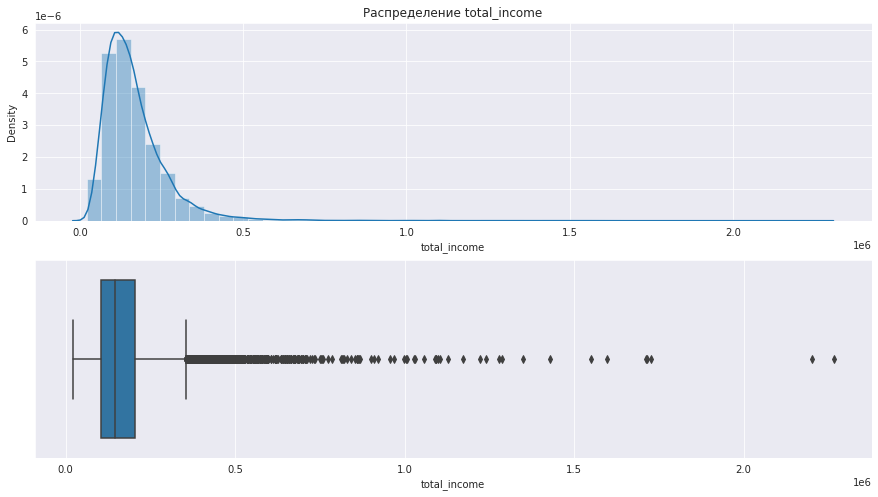

count      19,351.00
mean      167,422.30
std       102,971.57
min        20,667.26
25%       103,053.15
50%       145,017.94
75%       203,435.07
max     2,265,604.03
Name: total_income, dtype: float64

In [15]:
distribution(data['total_income'])

Доходы распределены нормальным образом с выбросами после 1.5 млн

Функция по замене значений в колонке_2 по медианным значениям колонки_1

In [16]:
def replace(data, column_1, column_2, threshold, operation):
    # Группируем данные
    median_values = data.pivot_table(index = column_1.name, values = column_2.name, aggfunc='median').reset_index()
    
    # Создаем словарь по сгруппированным данным
    our_dict = {}
    for i in range(len(median_values)):
        our_dict[median_values.loc[i ,column_1.name]] = median_values.loc[i, column_2.name]
    
    # Подставляем значение из словаря вместо значений column_2
    for i in range(len(data)):
        try:
            if operation == 0: 
                if pd.isna(data.loc[i, column_2.name]): # при пропусках
                    temp = data.loc[i, column_1.name] 
                    data.loc[i, column_2.name] = our_dict[temp]
            elif operation == 1:
                if data.loc[i, column_2.name] == threshold: # при равенстве числу
                    temp = data.loc[i, column_1.name] 
                    data.loc[i, column_2.name] = our_dict[temp]
            elif operation == 2:
                if data.loc[i, column_2.name] > threshold: # при превышении значения
                    temp = data.loc[i, column_1.name] 
                    data.loc[i, column_2.name] = our_dict[temp]
        except:
            print('отсутствующий индекс: ', data.index[i])

Заменяем пропущенные значения в __total_income__

In [17]:
replace(data, data['income_type'], data['total_income'], threshold = 0, operation = 0)

In [18]:
data['total_income'].isna().sum()

0

# Замена 0 в столбце "возраст"

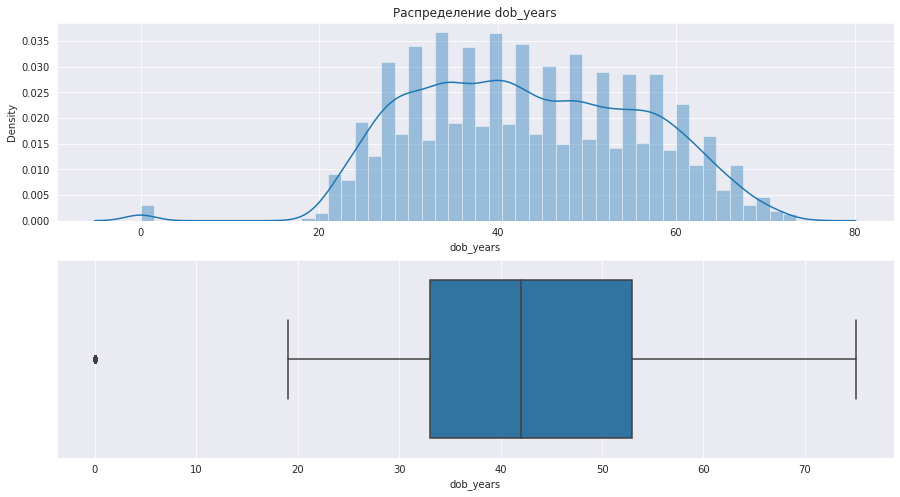

count   21,525.00
mean        43.29
std         12.57
min          0.00
25%         33.00
50%         42.00
75%         53.00
max         75.00
Name: dob_years, dtype: float64

In [19]:
distribution(data['dob_years'])

Чаще всего люди берут кредиты с 34 лет по 53 года

In [20]:
data[data['dob_years'] == 0].head(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
99,0,"346,541.62",0,Среднее,1,женат / замужем,0,F,пенсионер,0,"71,291.52",автомобиль
149,0,"2,664.27",0,среднее,1,в разводе,3,F,сотрудник,0,"70,176.44",операции с жильем
270,3,"1,872.66",0,среднее,1,женат / замужем,0,F,сотрудник,0,"102,166.46",ремонт жилью


In [21]:
len(data[data['dob_years'] == 0])

101

In [22]:
replace(data, data['income_type'], data['dob_years'], threshold = 0, operation = 1)

In [23]:
len(data[data['dob_years'] == 0])

0

In [24]:
data['dob_years'] = data['dob_years'].astype('int')

In [25]:
data['dob_years'].unique() # проверяем изменения

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51, 60, 59, 29, 55, 58, 71, 22, 73, 66,
       69, 19, 72, 70, 74, 75])

# Замена пропусков в столбце "стаж"

In [26]:
data.describe() # ознакамливаемся с данными по столбцам

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,"21,525.00","19,351.00","21,525.00","21,525.00","21,525.00","21,525.00","21,525.00"
mean,0.54,"66,914.73",43.50,0.82,0.97,0.08,"165,225.32"
std,1.38,"139,030.88",12.23,0.55,1.42,0.27,"98,043.67"
min,-1.00,24.14,19.00,0.00,0.00,0.00,"20,667.26"
25%,0.00,927.01,34.00,1.00,0.00,0.00,"107,798.17"
50%,0.00,"2,194.22",43.00,1.00,0.00,0.00,"142,594.40"
75%,1.00,"5,537.88",53.00,1.00,1.00,0.00,"195,549.94"
max,20.00,"401,755.40",75.00,4.00,4.00,1.00,"2,265,604.03"


Функция по категоризации возраста

In [27]:
def dob_years_grouped(years): 
    if years < 34:
        return 'до 34'
    elif 34 <= years < 43:
        return '33 - 41'
    elif 43 <= years < 53:
        return '43 - 52'
    elif 53 <= years:
        return '53+'

Добавляем новый столбец с категориями по возрасту

In [28]:
data['age_group'] = data['dob_years'].apply(dob_years_grouped)

In [29]:
data['age_group'].value_counts()

53+        5770
33 - 41    5377
до 34      5374
43 - 52    5004
Name: age_group, dtype: int64

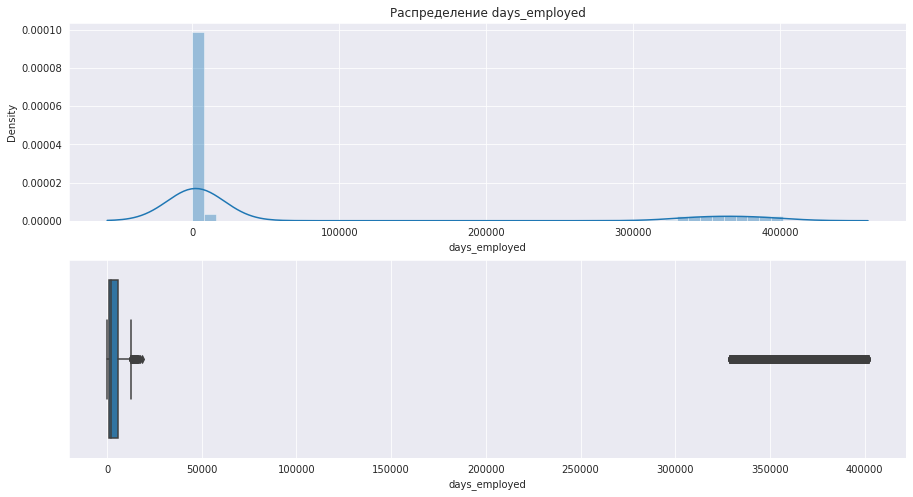

count    19,351.00
mean     66,914.73
std     139,030.88
min          24.14
25%         927.01
50%       2,194.22
75%       5,537.88
max     401,755.40
Name: days_employed, dtype: float64

In [30]:
distribution(data['days_employed'])

In [31]:
len(data[data['days_employed'] > 30000])

3445

Трудовой стаж более 30.000 дней выглядит неправдоподобно (более 80 лет), требуется уточнить происхождение информации

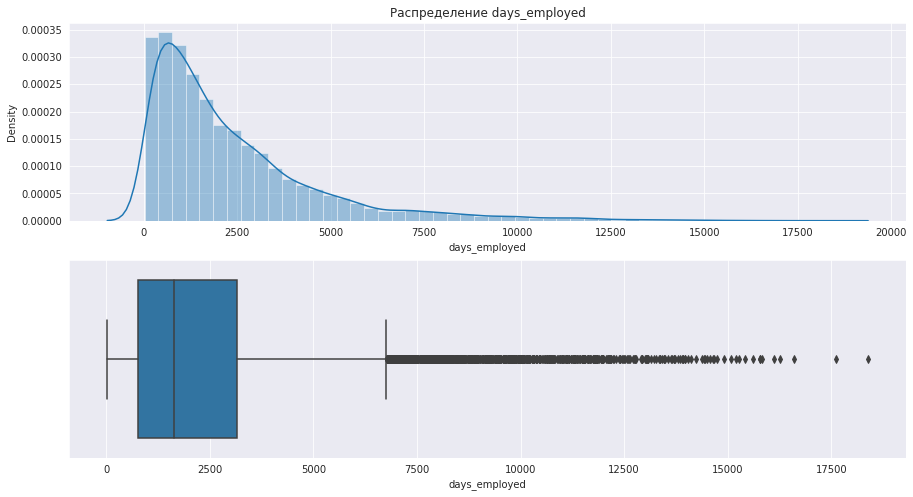

count   15,906.00
mean     2,353.02
std      2,304.24
min         24.14
25%        756.37
50%      1,630.02
75%      3,157.48
max     18,388.95
Name: days_employed, dtype: float64

In [32]:
distribution(data.loc[data['days_employed'] < 30000,'days_employed'])

Так как в __days_employed__ присутствуют нереальные значения, заменим их на Nan и вместе с изначальными пропусками заменим на значение медианы по возрастной группе. Так как таких значений много и терять их нецелесообразно

In [35]:
data.loc[data['days_employed'] > 30000, 'days_employed'] = None

In [36]:
data['days_employed'].isna().sum()

5619

In [37]:
replace(data, data['age_group'], data['days_employed'], threshold = 0, operation = 0)

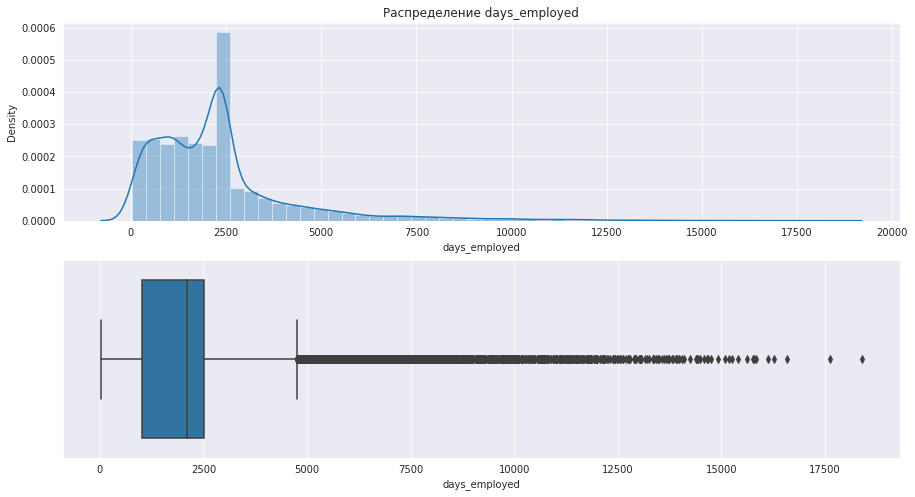

count   21,525.00
mean     2,301.34
std      1,992.10
min         24.14
25%      1,025.61
50%      2,105.63
75%      2,518.17
max     18,388.95
Name: days_employed, dtype: float64

In [38]:
distribution(data['days_employed'])

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
 12  age_group         21525 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 2.1+ MB


# Аномальные значения в _gender_

In [40]:
data[data['gender'] == 'XNA'].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
10701,0,"2,358.60",24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,"203,905.16",покупка недвижимости,до 34


Так как всего одна строка с некорректным значением пола, удалим данное наблюдение

In [41]:
data = data.drop(data[data['gender'] == 'XNA'].index)

In [42]:
data['gender'].value_counts()

F    14236
M     7288
Name: gender, dtype: int64

# Замена нестандартных значений в столбце "количество детей"

Значение -1 и 20, скорее всего, опечатки

In [43]:
data['children'].value_counts() # 

 0     14148
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [44]:
data.loc[data['children'] == 20].head(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
606,20,880.22,21,среднее,1,женат / замужем,0,M,компаньон,0,"145,334.87",покупка жилья,до 34
720,20,855.60,44,среднее,1,женат / замужем,0,F,компаньон,0,"112,998.74",покупка недвижимости,43 - 52
1074,20,"3,310.41",56,среднее,1,женат / замужем,0,F,сотрудник,1,"229,518.54",получение образования,53+


Значение равное 20 детям, вероятнее всего, опечатка. Так, например, в стр. 606 у человека в возрасте 21 год уже 20 детей.

In [45]:
data['children'] = data['children'].replace(-1,1) # меняем значение -1 на 1

In [46]:
data['children'] = data['children'].replace(20,2) # меняем значение 20 на 2

In [47]:
data['children'].value_counts() # проверяем изменение

0    14148
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

**Вывод**

1. в столбце _days_employed_ отрицательные значения преобразованы в положительные. Это могло быть вызвано тем, что в форме на сайте банка люди ошиблись в начальной и конечной дате стажа, в этом случае возможно доработать форму, чтобы дата окончания стажа не была позже даты его начала.
2. в столбце _total_income_ пустые значения заменены на значение медианы в разрезе типов дохода (income_type).
3. в столбце _days_employed_ стаж равный "0" заменили на значение медианы в разрезе типов дохода (income_type).
4. в столбце _days_employed_ пустые значения заменены на значение медианы в разрезе возрастных категорий. Для этого выполнена категоризация возраста по квантилям и добавлен новый столбец 'age_group'. Также аномальные значения более 30.000 дней стажа (более 80 лет) заменили также значений медианы в разрезе возрастных категорий.
5. в столбце _gender_ аномальное значение _XNA_ было удалено, так как кол-во строк с аномальным значением составило менее 1% общей выборки.
6. отрицательное значение в столбце _children_, а также выброс в количестве 20 детей были заменены на 1 ребенка и 2 детей, соответственно. Вероятнее всего, это человеческий фактор, так как в данных для человека 21 года соотвествует значение 20 детей, что наименее вероятно.Для исключения опечатки в количестве детей возможно в форме на сайте банка исключить ручной ввод и добавить выбор из предложенных значений.

### Замена типа данных

In [48]:
data.info() # проверка типов данных по столбцам

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21524 non-null  int64  
 1   days_employed     21524 non-null  float64
 2   dob_years         21524 non-null  int64  
 3   education         21524 non-null  object 
 4   education_id      21524 non-null  int64  
 5   family_status     21524 non-null  object 
 6   family_status_id  21524 non-null  int64  
 7   gender            21524 non-null  object 
 8   income_type       21524 non-null  object 
 9   debt              21524 non-null  int64  
 10  total_income      21524 non-null  float64
 11  purpose           21524 non-null  object 
 12  age_group         21524 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 2.3+ MB


In [49]:
data['days_employed'] = data['days_employed'].astype('int') # в столбце 'days_employed' меняем тип данных на целочисленный

In [50]:
data['total_income'] = data['total_income'].astype('int') # в столбце 'total_income' меняем тип данных на целочисленный

In [51]:
data.head(1) # проверка произведенных изменений

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,33 - 41


In [52]:
data.info() # проверка произведенных изменений

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21524 non-null  int64 
 1   days_employed     21524 non-null  int64 
 2   dob_years         21524 non-null  int64 
 3   education         21524 non-null  object
 4   education_id      21524 non-null  int64 
 5   family_status     21524 non-null  object
 6   family_status_id  21524 non-null  int64 
 7   gender            21524 non-null  object
 8   income_type       21524 non-null  object
 9   debt              21524 non-null  int64 
 10  total_income      21524 non-null  int64 
 11  purpose           21524 non-null  object
 12  age_group         21524 non-null  object
dtypes: int64(7), object(6)
memory usage: 2.3+ MB


**Вывод**

1. так как в столбцах _days_employed_ и _total_income_ более двух знаков после запятой (6 знаков), выполнили преобразование значений столбцов в целочисленный тип данных (_int_) для удобства осуществления математических вычислений

### Обработка дубликатов

In [53]:
data['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      667
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Приведем к нижнему регистру

In [54]:
data['education'] = data['education'].str.lower()

In [55]:
data['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      743
начальное                282
ученая степень             6
Name: education, dtype: int64

In [56]:
data[data.duplicated()].sort_values(by='dob_years', ascending=False).head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
9604,0,2373,71,среднее,1,гражданский брак,1,F,пенсионер,0,118514,на проведение свадьбы,53+
7938,0,2373,71,среднее,1,гражданский брак,1,F,пенсионер,0,118514,на проведение свадьбы,53+
9528,0,2373,66,среднее,1,вдовец / вдова,2,F,пенсионер,0,118514,операции со своей недвижимостью,53+
20187,0,2373,65,среднее,1,гражданский брак,1,F,пенсионер,0,118514,сыграть свадьбу,53+
17338,0,2373,64,среднее,1,гражданский брак,1,F,пенсионер,0,118514,сыграть свадьбу,53+


In [57]:
data.duplicated().sum() # считаем кол-во строк дубликатов

71

In [58]:
data = data.drop_duplicates().reset_index(drop=True) # удаляем дублированные строки, обновляем индексы

In [59]:
data.info() # проверяем кол-во строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21453 entries, 0 to 21452
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21453 non-null  int64 
 1   days_employed     21453 non-null  int64 
 2   dob_years         21453 non-null  int64 
 3   education         21453 non-null  object
 4   education_id      21453 non-null  int64 
 5   family_status     21453 non-null  object
 6   family_status_id  21453 non-null  int64 
 7   gender            21453 non-null  object
 8   income_type       21453 non-null  object
 9   debt              21453 non-null  int64 
 10  total_income      21453 non-null  int64 
 11  purpose           21453 non-null  object
 12  age_group         21453 non-null  object
dtypes: int64(7), object(6)
memory usage: 2.1+ MB


**Вывод**

1. Выявлены дубликаты в столбце _education_, вызванные написание букв в различных регистрах. Может быть вызвано тем, что люди заполняют от руки данную информацию в форме на сайте.
2. Для исключения дубликатов в столбце _education_ использовался метод str.lower() для приведения значений в нижний регистр, что позволило значительно сократить кол-во уникальных значений.
3. Для поиска дублированных строк в data использовался метод _duplicated()_, для удаления дулирующих строк (71 строка) - метод _drop_duplicates()_.
4. Возможно запредить ручной ввод данных об образовании и добавить возможность выбора из списка для исключения дубликатов.

### Лемматизация

In [60]:
data['purpose'].value_counts() # просморт уникальных значений целей кредита

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
жилье                                     646
покупка жилья                             646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      620
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

In [61]:
m = Mystem()

In [62]:
try:                                 # функция по подсчету Лемм по целям кредита
    text =[]
    for row in data['purpose']:
        lemmas = m.lemmatize(row)
        text += lemmas
    print(Counter(text))
except:
    print('Не сработало')

Counter({' ': 33569, '\n': 21453, 'недвижимость': 6350, 'покупка': 5896, 'жилье': 4460, 'автомобиль': 4306, 'образование': 4013, 'с': 2918, 'операция': 2604, 'свадьба': 2324, 'свой': 2230, 'на': 2222, 'строительство': 1878, 'высокий': 1374, 'получение': 1314, 'коммерческий': 1311, 'для': 1289, 'жилой': 1230, 'сделка': 941, 'дополнительный': 906, 'заниматься': 904, 'проведение': 768, 'сыграть': 765, 'сдача': 651, 'семья': 638, 'собственный': 635, 'со': 627, 'ремонт': 607, 'подержанный': 486, 'подержать': 478, 'приобретение': 461, 'профильный': 436})


In [63]:
def get_lemma (column): # функция по категоризации данных по значению леммы из столбца 'purpose'
    lemmas = m.lemmatize(column)
    if 'свадьба' in lemmas:
        return 'свадьба'
    elif 'недвижимость' in lemmas:
        return 'недвижимость'
    elif 'жилье' in lemmas:
        return 'недвижимость'
    elif 'автомобиль' in lemmas:
        return 'автомобиль'
    elif 'образование' in lemmas:
        return 'образование'
    else:
        return 'не распознано'

применение функции и добавление нового столбца с обобщенными категориями по столбцу _purpose_

In [64]:
data['lemmas'] = data['purpose'].apply(get_lemma)

In [65]:
data['lemmas'].value_counts().sort_values(ascending=False)

недвижимость    10810
автомобиль       4306
образование      4013
свадьба          2324
Name: lemmas, dtype: int64

**Вывод**

1. проведена лемматизация по целям кредита и методом _Counter_ подсчитаны наиболее часто встречающиеся леммы.
2. осуществлена категоризация данных по леммам в разрезе целей кредита: свадьба, недвижимость, автомобиль, образование.
3. добавлен новый столбец _lemmas_ с категорией цели кредита (наиболее популярен кредит на недвижимость)


### Категоризация данных

In [66]:
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,"21,453.00","21,453.00","21,453.00","21,453.00","21,453.00","21,453.00","21,453.00"
mean,0.48,"2,301.59",43.48,0.82,0.97,0.08,"165,317.77"
std,0.76,"1,995.27",12.23,0.55,1.42,0.27,"98,189.24"
min,0.00,24.00,19.00,0.00,0.00,0.00,"20,667.00"
25%,0.00,"1,023.00",33.00,1.00,0.00,0.00,"107,620.00"
50%,0.00,"2,105.00",42.00,1.00,0.00,0.00,"142,594.00"
75%,1.00,"2,523.00",53.00,1.00,1.00,0.00,"195,818.00"
max,5.00,"18,388.00",75.00,4.00,4.00,1.00,"2,265,604.00"


In [67]:
def income_grouped(income): # функция по категоризации дохода
    if 0 <= income < 107620:
        return 'low'
    elif 107620 <= income < 142594:
        return 'middle'
    elif 142594 <= income <= 195818:
        return 'high'
    elif 195818 < income:
        return 'extra_high'

In [68]:
data['income_groupe'] = data['total_income'].apply(income_grouped) # добавляем новый столбец с категориями по доходу

In [69]:
def having_children(number): # функция по определению наличия детей
    if 0 < number:
        return 'есть дети'
    elif number == 0:
        return 'нет детей'

In [70]:
data['having_children'] = data['children'].apply(having_children) # добавляем столбец со значение наличия ребенка в семье

In [71]:
data['having_children'].value_counts() # проверяем

нет детей    14090
есть дети     7363
Name: having_children, dtype: int64

**Вывод**

1. проведена категоризация данных по уровню дохода, выделено 4 группы по квантилям 25%-50-75
2. добавлен новый столбец _income_groupe_ с категорией дохода
3. проведена категоризация данных по наличию детей в семье.
4. добавлен новый столбец _having_children_.
5. 
- в п. 2.1 выполнена категоризация по возрастной категории и добавлен столбец _age_group_.
- в п. 2.4 выполнена категоризация данных по цели кредита и добавлен столбец _lemmas_.

## Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Функция по группировке данных по колонке_1 и добавлением столбца с соотношением

In [72]:
def count(data, column_1, column_2):
    grouped = data.groupby(column_1.name, as_index=False).agg({column_2.name:['count', 'sum']}) 
    grouped['ratio'] = grouped[column_2.name]['sum'] / grouped[column_2.name]['count'] * 100
    display(grouped.sort_values(by='ratio', ascending=True))

In [73]:
count(data, data['having_children'], data['debt'])

having_children   debt       ratio
                   count   sum      
1       нет детей  14090  1063  7.54
0       есть дети   7363   678  9.21

Заемщики с детьми чаще имели просроченную задолженность, возможно, при нехватке денежных средств расставляли приоритет в сторону детей

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [74]:
count(data, data['family_status'], data['debt'])

family_status   debt      ratio
                          count  sum      
2         вдовец / вдова    959   63  6.57
1              в разводе   1195   85  7.11
4        женат / замужем  12339  931  7.55
3       гражданский брак   4150  388  9.35
0  Не женат / не замужем   2810  274  9.75

Люди, находящиеся в официальном браке, либо состоящие в нем ранее, имели меньший процент задолженности по кредитам.
Следовательно, высокий процент наличия задолженности по кредиту у не женатых (не замужних) людей и людей в гражданском браке.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [75]:
count(data, data['income_groupe'], data['debt'])

income_groupe  debt      ratio
                count  sum      
0    extra_high  5363  383  7.14
2           low  5363  427  7.96
1          high  6317  546  8.64
3        middle  4410  385  8.73

Люди с самым высоким порогом дохода имеют наименьшее количество задолженности (умеют считать деньги и не хотят пеерплачивать по процентам), на втором месте люди с низким доходом, вероятно, так как имеют немного кредитов и тщательно следят за платежами во избежании просрочек, чтобы не платить дополнительных денежных средств по пеням и штрафам. Чаще всех имели задолженность люди со средним уровнем дохода - 8,7% и высоким - 8,6%, вероятно, так как сильно закредитованы и имеют более одного кредита.

- Как разные цели кредита влияют на его возврат в срок?

In [76]:
count(data, data['lemmas'], data['debt'])

lemmas   debt      ratio
                 count  sum      
1  недвижимость  10810  782  7.23
3       свадьба   2324  186  8.00
2   образование   4013  370  9.22
0    автомобиль   4306  403  9.36

Самая низкая вероятность задолженности по кредиту у людей, взявших кредит на покупку недвижимости, вероятно, так как это крупные суммы для них и обдуманный шаг, так как оформление занимает длительное время.  
Чуть чаще имеют задолженность люди, взявшие кредит на свадьбу, вероятно, вызвано тем, что относительно небольшая сумма кредита.  
Чаще остальных имели просрочки люди, взявшие кредит на автомобиль - 9,4% и образование - 9,2%.

## Общий вывод

1. Получили таблицу о платежеспособности клиентов банка, оформивших кредит, для анализа на предмет зависимостей:
- семейного положения и задолженности по кредиту;
- наличия детей и задолженности по кредиту.
2. В данных выявлены следующие недостатки:
- отсутствующие значения (столбцы: стаж и доход);
- некорректные значения (столбцы: стаж и пол);
- аномальные значения (столбцы: количество детей);
- дублирующиеся строки (столбцы: образование и цель кредита).
3. Для исключения недостатков рассмотреть следующие доработки:
- обязательность заполнения форм: стаж и доход;
- отменить ручной ввод и предоставить выбор из списка в формах: пол, количество детей, образование, цель кредита;
- установить проверку на положительные значения в форме стаж, не превыщающие, например, 30.000 дней
4. Данные обработаны.
5. Выявлено:
- что семейное положение влияет на вероятность возникновения задолженности по кредиту. Люди, состояющие в официальном браке ранее или на текущий момент реже остальных имели задолженность по кредиту;
- что наличие детей влияет на вероятность возникновения задолженности по кредиту. Люди имеющие детей, чаще имеют просрочки по кредитам.

